In [1]:
"""
Main runner for Marco D’Amico — Advanced Data Science Project
Machine Learning–Based Stock Selection and Trading Strategy
------------------------------------------------------------
This script runs the full pipeline:
1. Download data
2. Build features
3. Train all ML models (walk-forward)
4. Select best model
5. Backtest portfolio
6. Generate figures, tables and robustness checks
"""


'\nMain runner for Marco D’Amico — Advanced Data Science Project\nMachine Learning–Based Stock Selection and Trading Strategy\n------------------------------------------------------------\nThis script runs the full pipeline:\n1. Download data\n2. Build features\n3. Train all ML models (walk-forward)\n4. Select best model\n5. Backtest portfolio\n6. Generate figures, tables and robustness checks\n'

In [2]:
# === SETUP ===

import os, sys

# Move from /notebooks to project root
os.chdir("..")
sys.path.append(os.getcwd())

print("Working directory:", os.getcwd())


Working directory: /files/Marco_D-Amico_Project


In [3]:
# === IMPORTS ===

import pandas as pd
from settings import FEATURES_BASE, TOP_FRACS, COSTS, SUBPERIODS, SEED
from data.loader import download_prices
from features.build_dataset import build_ml_dataset
from models.models import MODELS
from models.walkforward import walk_forward_predict
from portfolio.backtest import (
    backtest_long_top,
    sensitivity_grid,
    backtest_long_short,
)
from metrics.ml import calib_points
from metrics.perf import cagr, ann_vol, sharpe, max_drawdown
from report.tables import perf_table
from report.plots import plot_equity, plot_underwater, plot_calibration


In [4]:
# === DATA PREPARATION ===

# load/download raw prices
if not os.path.exists("data/sp500_prices.csv"):
    print("Downloading price data...")
    download_prices(start="2020-11-01", end="2025-11-01")
else:
    print("Price data already available.")

# load/build ML dataset
if not os.path.exists("data/ml_dataset.csv"):
    print("Building ML dataset...")
    df_ml = build_ml_dataset()
else:
    print("ML dataset already exists — loading it.")
    df_ml = pd.read_csv("data/ml_dataset.csv", parse_dates=["Date"])

# clean & sort dataset
df_ml = df_ml.sort_values(["Date", "Ticker"])

print(f"Dataset ready: {len(df_ml):,} rows, {df_ml['Ticker'].nunique()} tickers")
display(df_ml.head())


Price data already available.
ML dataset already exists — loading it.
Dataset ready: 26,346 rows, 501 tickers


,Date,Ticker,ret_1m,ret_3m,ret_6m,vol_3m,ma_ratio_50D,RSI_14D,ret_next1m,target
0,2021-05-31,A,0.033598,0.133286,0.185347,0.013568,1.054390,67.643837,0.070079,1
1,2021-05-31,AAPL,-0.050497,0.029372,0.050048,0.016911,0.975409,44.450002,0.099109,1
2,2021-05-31,ABBV,0.015247,0.063453,0.108400,0.012492,1.025476,37.977730,-0.004947,0
3,2021-05-31,ABT,-0.028564,-0.022556,0.086213,0.012052,0.974941,41.815567,-0.006172,0
4,2021-05-31,ACGL,0.004533,0.113624,0.238820,0.012401,1.008643,49.696976,-0.023816,0


In [5]:
# === TRAIN ALL MODELS ===

results, pred_store = [], {}
for name, model in MODELS.items():
    print(f"Training: {name}")
    pred, auc, brier = walk_forward_predict(
        df_ml, FEATURES_BASE, model, start_idx=12
    )
    results.append({"Model": name, "AUC": auc, "Brier": brier})
    pred_store[name] = pred # store model predictions

# compare models
res = pd.DataFrame(results).sort_values("AUC", ascending=False)
display(res)

# select best model
best = res.iloc[0]["Model"]
print(f"Best model selected: {best}")


Training: Logit_L2
Training: Logit_noReg
Training: RF
Training: GB
Training: Ridge
Training: XGB


,Model,AUC,Brier
2,RF,0.494223,0.256083
3,GB,0.491260,0.262146
5,XGB,0.488624,0.262318
4,Ridge,0.486965,0.252197
0,Logit_L2,0.486599,0.257436
1,Logit_noReg,0.486587,0.257463


Best model selected: RF


In [6]:
# === BUILD df_pred FOR BEST MODEL ===

pred_df = pred_store[best]   # predictions: Date, Ticker, target, p_up

# attach p_up to main dataset
df_pred = df_ml.merge(
    pred_df[["Date", "Ticker", "p_up"]],
    on=["Date", "Ticker"],
    how="left",
)


In [7]:
# pick fraction (first) and cost (second) following main() logic
top_frac = TOP_FRACS[0] if isinstance(TOP_FRACS, (list, tuple)) else TOP_FRACS

if isinstance(COSTS, (list, tuple)) and len(COSTS) > 1:
    cost = COSTS[1]
else:
    cost = 0.0005


In [8]:
# === BACKTEST BEST MODEL (LONG-ONLY) ===

bt = backtest_long_top(df_pred, top_frac=top_frac, cost=cost) # run ML strategy
print("Long-only ML vs Benchmarks")
display(perf_table(bt)) # compare with Equal-Weight and Momentum6M


Long-only ML vs Benchmarks


,CAGR,Vol,Sharpe,MaxDD
ML Top10%,0.117727,0.184957,0.636511,-0.127386
Equal-Weight,0.142341,0.171352,0.830694,-0.113253
Momentum6M Top10%,0.269124,0.232834,1.155861,-0.121597


In [9]:
# === BACKTEST LONG-SHORT (TOP vs BOTTOM) ===

bt_ls = backtest_long_short(df_pred, top_frac=top_frac, cost=cost) # LS strategy
if bt_ls.empty:
    print("Long-short ML: no valid months — skipping.")
else:
    # compute LS performance metrics
    ls_metrics = {
        "CAGR_LS":  cagr(1 + bt_ls["ret_long_short"]),
        "Vol_LS":   ann_vol(bt_ls["ret_long_short"]),
        "Sharpe_LS": sharpe(bt_ls["ret_long_short"]),
        "MaxDD_LS": max_drawdown(bt_ls["cum_ret_long_short"]),
    }

    print("\n Long-short ML (Top vs Bottom)")
    display(pd.DataFrame([ls_metrics]))



 Long-short ML (Top vs Bottom)


,CAGR_LS,Vol_LS,Sharpe_LS,MaxDD_LS
0,-0.137319,0.132539,-1.036059,-0.422069


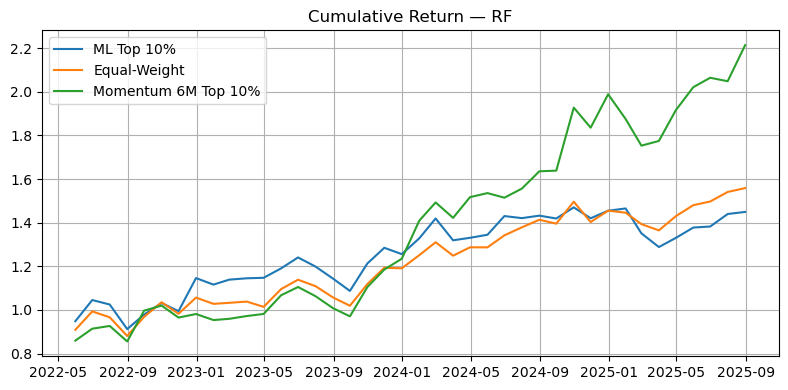

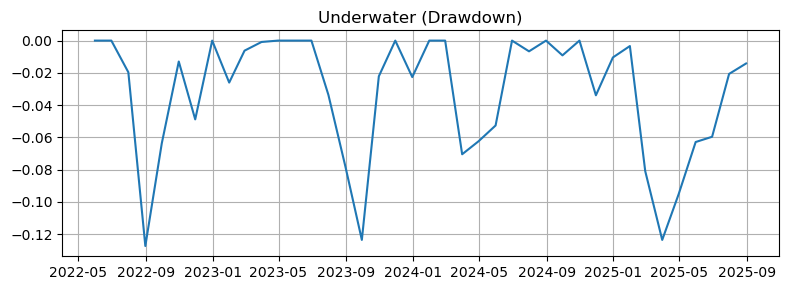

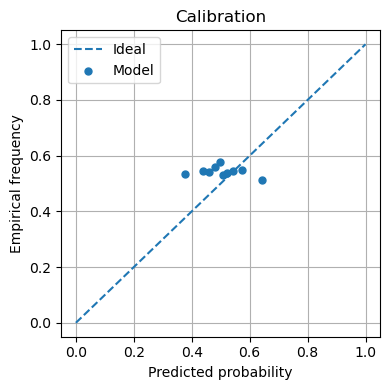

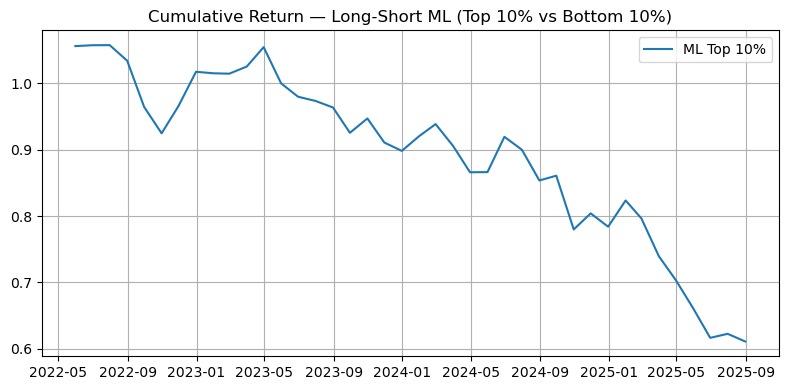

In [10]:
# === PLOTS ===

# Equity curve Long-only
plot_equity(bt, f"Cumulative Return — {best}")

# Underwater plot Long-only (ML)
plot_underwater(bt["cum_ret_ml"])

# Calibration curve
mask = df_pred["p_up"].notna()
cal = calib_points(df_pred.loc[mask, "target"], df_pred.loc[mask, "p_up"])
plot_calibration(cal)

# Equity curve Long-Short
if not bt_ls.empty:
    tmp_ls = bt_ls.rename(columns={"cum_ret_long_short": "cum_ret_ml"})
    plot_equity(
        tmp_ls,
        f"Cumulative Return — Long-Short ML (Top {int(top_frac*100)}% vs Bottom {int(top_frac*100)}%)"
    )


In [11]:
# === SUBPERIOD ANALYSIS (LONG-ONLY) ===

for s_str, e_str in SUBPERIODS:
    s = pd.to_datetime(s_str)
    e = pd.to_datetime(e_str)

    # filter period
    sub = df_pred[(df_pred["Date"] >= s) & (df_pred["Date"] <= e)]
    if sub["p_up"].notna().sum() == 0:
        print(f"Subperiod {s.date()}–{e.date()}: no predicted months — skipping.\n")
        continue

    # backtest on subperiod
    bt_sub = backtest_long_top(sub, top_frac=top_frac, cost=cost)
    if bt_sub.empty:
        print(f"Subperiod {s.date()}–{e.date()}: empty backtest — skipping.\n")
        continue

    print(f"\nSubperiod {s.date()}–{e.date()}")
    display(perf_table(bt_sub))


Subperiod 2019-01-01–2021-12-31: no predicted months — skipping.


Subperiod 2022-01-01–2024-12-31


,CAGR,Vol,Sharpe,MaxDD
ML Top10%,0.150895,0.194215,0.776950,-0.127386
Equal-Weight,0.151002,0.185737,0.812987,-0.113253
Momentum6M Top10%,0.303066,0.191390,1.583503,-0.121597


In [12]:
# === SENSITIVITY ANALYSIS ===

print("\nSensitivity Analysis (Long-Only ML)")
sens = sensitivity_grid(df_pred, top_fracs=TOP_FRACS, costs=COSTS) # test multiple params
display(sens.sort_values(["top_frac", "cost"]))



Sensitivity Analysis (Long-Only ML)


,period,top_frac,cost,CAGR_ml,Sharpe_ml
0,FULL,0.1,0.0000,0.124399,0.672583
1,2022-01-01–2024-12-31,0.1,0.0000,0.157749,0.812240
2,FULL,0.1,0.0005,0.117727,0.636511
3,2022-01-01–2024-12-31,0.1,0.0005,0.150895,0.776950
4,FULL,0.1,0.0010,0.111092,0.600635
5,2022-01-01–2024-12-31,0.1,0.0010,0.144079,0.741851
6,FULL,0.2,0.0000,0.121057,0.706077
7,2022-01-01–2024-12-31,0.2,0.0000,0.156185,0.862393
8,FULL,0.2,0.0005,0.114404,0.667275
9,2022-01-01–2024-12-31,0.2,0.0005,0.149340,0.824601
